## LSTM

###  탠서플로부분 꼭 코랩가서 해라

In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os 
import pandas as pd

import warnings
warnings.simplefilter('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### 데이터 셋

In [20]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('exchange_rate_fix_20210223.xls.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,"1,099.70",6764.11,0.87,NaN,90.95,0.47,"3,133.73"
1758,2021.02.18,"1,107.70",6652.76,0.87,NaN,90.59,0.49,"3,086.66"
1759,2021.02.19,"1,105.70",6712.32,0.86,NaN,90.36,0.51,"3,107.62"
1760,2021.02.22,"1,107.10",6635.92,0.86,NaN,90.01,0.50,"3,079.75"
1761,2021.02.23,"1,106.50",6607.24,0.86,NaN,90.17,0.49,"3,070.09"


In [8]:
#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","KRX100", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))

In [9]:
#천단위 쉼표 제거
df1['ExchangeRate'] = df1['ExchangeRate'].str.replace(',','')
df1['KOSPI'] = df1['KOSPI'].str.replace(',','')
df1.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.70,6764.11,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.70,6652.76,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.70,6712.32,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.10,6635.92,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.50,6607.24,0.86,NaN,90.17,0.49,3070.09


In [10]:
#오브젝트형 데이터 실수로 형변환
df1["KOSPI"] = pd.to_numeric(df1.KOSPI, errors='coerce')
df1["ExchangeRate"] = pd.to_numeric(df1.ExchangeRate, errors='coerce')

In [11]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     1
KRX100           6
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [12]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

df_intp.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.7,6764.11,0.87,0.0815,90.95,0.47,3133.73
1758,2021.02.18,1107.7,6652.76,0.87,0.0815,90.59,0.49,3086.66
1759,2021.02.19,1105.7,6712.32,0.86,0.0815,90.36,0.51,3107.62
1760,2021.02.22,1107.1,6635.92,0.86,0.0815,90.01,0.50,3079.75
1761,2021.02.23,1106.5,6607.24,0.86,0.0815,90.17,0.49,3070.09


In [13]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

In [15]:
df_intp.head()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


In [17]:
#날짜가 인덱스인 경우도 생성 해놓자
df_date = df_intp.set_index('Date')
df_date.head()

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


<AxesSubplot:xlabel='Date'>

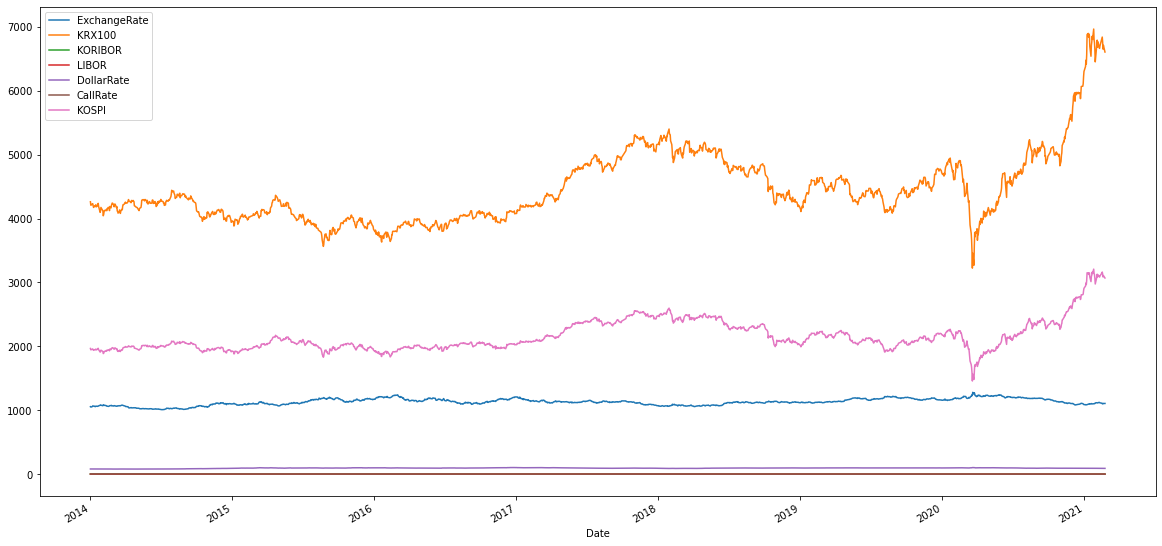

In [14]:
#시각화 해보자
df_intp.plot(x="Date",figsize = (20,10))

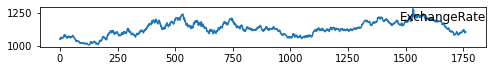

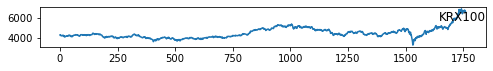

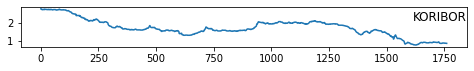

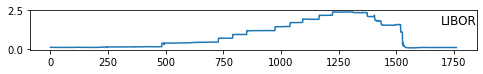

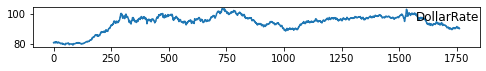

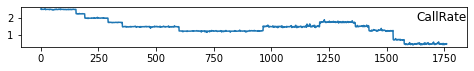

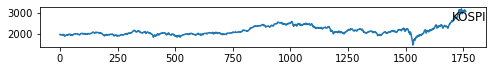

In [19]:
#개별 시각화
groups = [0,1,2,3,4,5,6]
i = 1
#그래프
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(df_date.values[:,group])
    plt.title(df_date.columns[group], y= 0.5, loc= 'right')
    i +=1
    plt.show()

In [ ]:
## 시계열 변환


## 표준화 과정
- min_max 표준화로 해보자
- 가우시안 분포에 해당하지 않는것같기 때문

In [65]:
from sklearn.preprocessing import MinMaxScaler

#scaler 객체 생성
scaler = MinMaxScaler(feature_range = (-1,1))

#데이터셋 변환
scaler.fit(df_date)
date_scaler = scaler.transform(df_date)

#transform 변환을 하면 배열 형식으로 바뀌는데 그걸 다시 데이터 프레임 형식으로 넘기자
df_scaler = pd.DataFrame(date_scaler, columns = df_date.columns, index = df_date.index)
df_scaler

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,-0.657817,-0.444864,1.000000,-0.961862,-0.871102,0.990431,-0.418106
2014-01-03,-0.693953,-0.474051,1.000000,-0.962372,-0.856965,0.980861,-0.442145
2014-01-06,-0.666667,-0.467584,0.990050,-0.962798,-0.869439,0.961722,-0.433991
2014-01-07,-0.606932,-0.461213,0.970149,-0.964413,-0.855301,0.980861,-0.426956
2014-01-08,-0.564897,-0.461635,0.970149,-0.964498,-0.840333,0.971292,-0.427504
...,...,...,...,...,...,...,...
2021-02-17,-0.330383,0.891532,-0.900498,-0.973852,-0.026195,-0.961722,0.914055
2021-02-18,-0.271386,0.832020,-0.900498,-0.973852,-0.056133,-0.942584,0.860302
2021-02-19,-0.286136,0.863852,-0.910448,-0.973852,-0.075260,-0.923445,0.884238


## 훈련 셋 분류
- 먼저 훈련, 테스트셋 분류 (8:2)
- 훈련셋을 검증과 훈련셋으로 다시 분류 (1:9)

In [58]:
train_size = int(0.8 * len(df_scaler))
train = df_scaler.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(df_scaler.iloc[:train_size, [1,2,3,4,5,6]]),pd.DataFrame(df_scaler.iloc[:train_size, 0])
x_test, y_test = pd.DataFrame(df_scaler.iloc[train_size:, [1,2,3,4,5,6]]), pd.DataFrame(df_scaler.iloc[train_size:, 0])

x_test.head()

,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,
2019-09-23,0.333360,0.373134,0.763924,0.804990,0.516746,0.362041
2019-09-24,0.339562,0.373134,0.761586,0.794179,0.516746,0.367374
2019-09-25,0.325081,0.373134,0.761054,0.823285,0.526316,0.351586
2019-09-26,0.326904,0.378109,0.756433,0.827027,0.526316,0.352231
2019-09-27,0.311902,0.378109,0.755264,0.826195,0.531100,0.338191


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

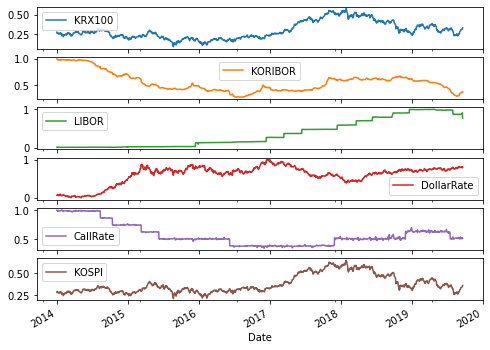

In [59]:
x_train.plot(subplots = True)

In [60]:
#훈련데이터를 valid와 훈련데이터로 다시 나누자
train_valid_size = int(0.9 * len(x_train))
train = x_train.iloc[:train_valid_size, :]

x_train_f, y_train_f = pd.DataFrame(x_train.iloc[:train_size, [0,1,2,3,4,5]]),pd.DataFrame(y_train.iloc[:train_size, 0])
x_valid, y_valid = pd.DataFrame(x_train.iloc[train_size:, [0,1,2,3,4,5]]), pd.DataFrame(y_train.iloc[train_size:, 0])
y_train_f.tail()

,ExchangeRate
Date,
2019-09-16,0.672935
2019-09-17,0.645649
2019-09-18,0.661504
2019-09-19,0.669617
2019-09-20,0.686578


In [ ]:
 def multivariate_data(dataset, target, start_index, end_index, 
                       history_size, target_size, step, single_step=False):
        data  =[]
        labels = []
        
        start_index